# Compare networks on ImageNet

In this notebook we show how one can use **iNNvestigate** to analyze the prediction of *different* ImageNet-models!

This notebook is an extension of the [Comparing networks on ImagenNet](imagenet_network_comparison.ipynb) notebook.

-----


Note this script is fairly slow, because we are rebuilding models times analysis methods many computational graphs.

-----

**To use this notebook please download the example images using the following script:**

`innvestigate/examples/images/wget_imagenet_2011_samples.sh`

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.simplefilter("ignore")

In [2]:
%matplotlib inline

import imp
import os

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications import densenet

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.backend as ibackend

# Use utility libraries to focus on relevant iNNvestigate routines.
import utils as eutils
import utils.imagenet as imagenetutils

## Models, data and analyzers

We choose a set of ImageNet models:

In [3]:
# Choose a list of models and preprocessing functions.
# fmt: off
networks = [
    # NAME          # MODEL                     # PREPROCESSING FUNCTION
    ("VGG16",       vgg16.VGG16(),              vgg16.preprocess_input),
    ("ResNet50",    resnet50.ResNet50(),        resnet50.preprocess_input),
    ("InceptionV3", inception_v3.InceptionV3(), inception_v3.preprocess_input),
    ("DenseNet121", densenet.DenseNet121(),     densenet.preprocess_input),
]
# fmt: on
n_nets = len(networks)

Instructions for updating:
Colocations handled automatically by placer.


The following function will load a specific model, load the data in the respective format and create analyzers for this model.

**For a better understanding of this part we refer to the [Comparing networks on ImagenNet](imagenet_network_comparison.ipynb) notebook, from which this code segment is adopted from.**

In [4]:
def prepare_model_data_and_analyzers(network):
    # Build the model.
    name, model, preprocess_input = network
    model.compile(optimizer="adam", loss="categorical_crossentropy")

    # Handle input depending on model and backend.
    channels_first = keras.backend.image_data_format() == "channels_first"
    color_conversion = "BGRtoRGB"  # keras.applications use BGR format

    # Get some example test set images.
    images, label_to_class_name = eutils.get_imagenet_data(model.input_shape[1])

    if not len(images):
        raise Exception(
            "Please download the example images using: "
            "'innvestigate/examples/images/wget_imagenet_2011_samples.sh'"
        )

    input_range = (-128, 128)  # format used by keras.applications
    noise_scale = (input_range[1] - input_range[0]) * 0.1

    # Methods we use and some properties.
    # fmt: off
    methods = [
        # NAME                  OPT.PARAMS                  POSTPROC FXN            TITLE
        # Show input.
        ("input",               {},                         imagenetutils.image,    "Input"),
        # Function
        ("gradient",            {"postprocess": "abs"},     imagenetutils.graymap,  "Gradient"),
        ("smoothgrad",          {"augment_by_n": 64, 
                                "noise_scale": noise_scale, 
                                "postprocess": "square"},   imagenetutils.graymap,  "SmoothGrad"),
        # Signal
        ("deconvnet",           {},                         imagenetutils.bk_proj,  "Deconvnet"),
        ("guided_backprop",     {},                         imagenetutils.bk_proj,  "Guided Backprop"),
        # Interaction
        ("deep_taylor.bounded", {"low": input_range[0], 
                                "high": input_range[1]},   imagenetutils.heatmap,  "DeepTaylor"),
        ("input_t_gradient",    {},                         imagenetutils.heatmap,  "Input * Gradient"),
        ("integrated_gradients",
                                {"reference_inputs": input_range[0], 
                                "steps": 64},               imagenetutils.heatmap,  "Integrated Gradients"),
        ("lrp.z",               {},                         imagenetutils.heatmap,  "LRP-Z"),
        ("lrp.epsilon",         {"epsilon": 1},             imagenetutils.heatmap,  "LRP-Epsilon"),
        ("lrp.sequential_preset_a_flat",
                                {"epsilon": 1},             imagenetutils.heatmap,  "LRP-PresetAFlat"),
        ("lrp.sequential_preset_b_flat",
                                {"epsilon": 1},             imagenetutils.heatmap,  "LRP-PresetBFlat"),
    ]
    # fmt: on

    # Create model without trailing softmax
    model_wo_softmax = innvestigate.model_wo_softmax(model)

    # Create analyzers.
    analyzers = []
    for method in methods:
        try:
            analyzer = innvestigate.create_analyzer(
                method[0],  # analysis method identifier
                model_wo_softmax,  # model without softmax output
                **method[1]
            )  # optional analysis parameters
        except innvestigate.NotAnalyzeableModelException:
            # Not all methods work with all models.
            analyzer = None
        analyzers.append(analyzer)

    return (
        color_conversion,
        channels_first,
        images,
        label_to_class_name,
        methods,
        model,
        model_wo_softmax,
        analyzers,
    )

## Analysis

Now we analyze each image with the different networks and different analyzers:

In [5]:
analyses = {}
texts = {}

for network in networks:
    name, _, preprocess_input = network
    print(f"Creating analyses for network {name}.")
    (
        color_conversion,
        channels_first,
        images,
        label_to_class_name,
        methods,
        model,
        model_wo_softmax,
        analyzers,
    ) = prepare_model_data_and_analyzers(network)

    analysis = np.zeros([len(images), len(analyzers), *model.input_shape[1:]])
    text = []

    for i, (x, y) in enumerate(images):
        # Add batch axis.
        x = x[None, :, :, :]
        x_pp = preprocess_input(x)

        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x_pp)[0]
        prob = model.predict_on_batch(x_pp)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(
            (
                "%s" % label_to_class_name[y],  # ground truth label
                "%.2f" % presm.max(),  # pre-softmax logits
                "%.2f" % prob.max(),  # probabilistic softmax output
                "%s" % label_to_class_name[y_hat],  # predicted label
            )
        )

        for aidx, analyzer in enumerate(analyzers):
            if methods[aidx][0] == "input":
                # Do not analyze, but keep not preprocessed input.
                a = x / 255
            elif analyzer:
                # Analyze.
                a = analyzer.analyze(x_pp)

                # Apply common postprocessing, e.g., re-ordering the channels for plotting.
                a = imagenetutils.postprocess(a, color_conversion, channels_first)
                # Apply analysis postprocessing, e.g., creating a heatmap.
                a = methods[aidx][2](a)
            else:
                a = np.zeros_like(x)
            # Store the analysis.
            analysis[i, aidx] = a[0]

        analyses[name] = analysis
        texts[name] = text

Creating analyses for network VGG16.


Next, we visualize the analysis results:

Image nr. 0, true label: baseball


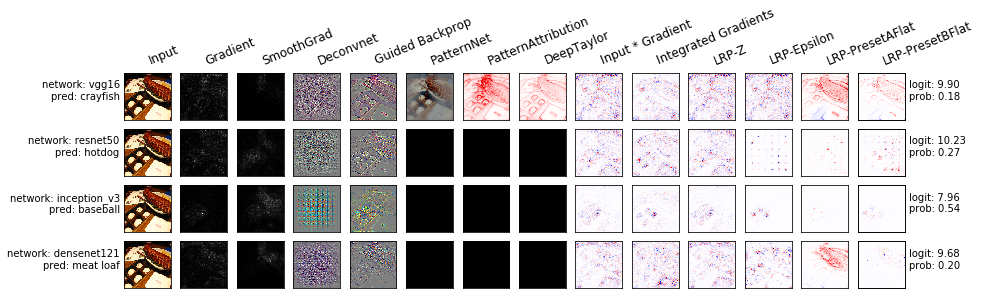

Image nr. 1, true label: bell pepper


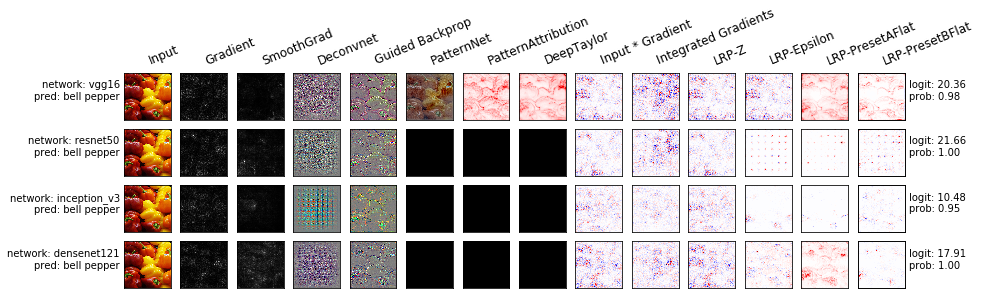

Image nr. 2, true label: ice lolly


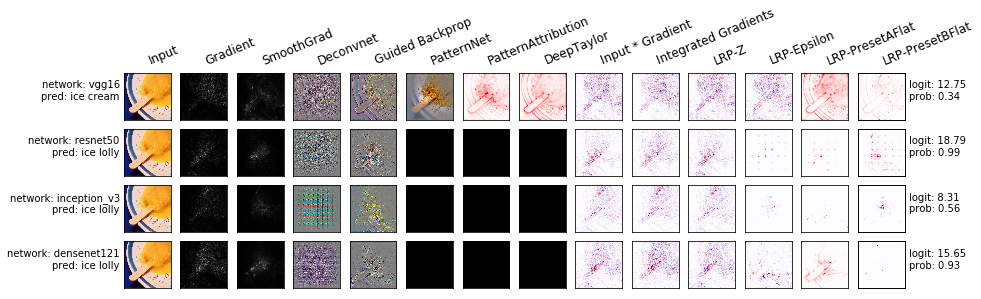

Image nr. 3, true label: broom


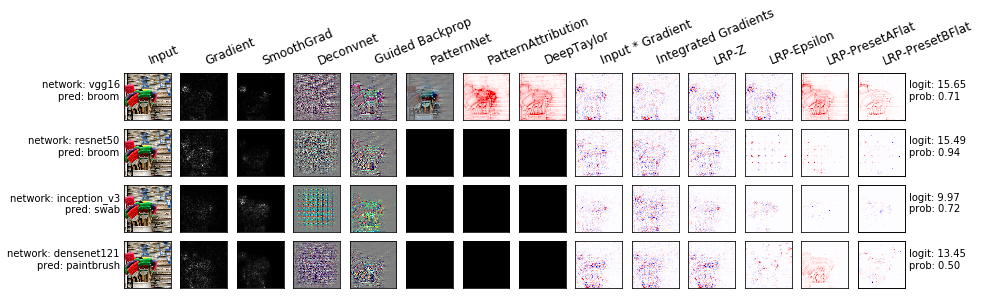

Image nr. 4, true label: abaya


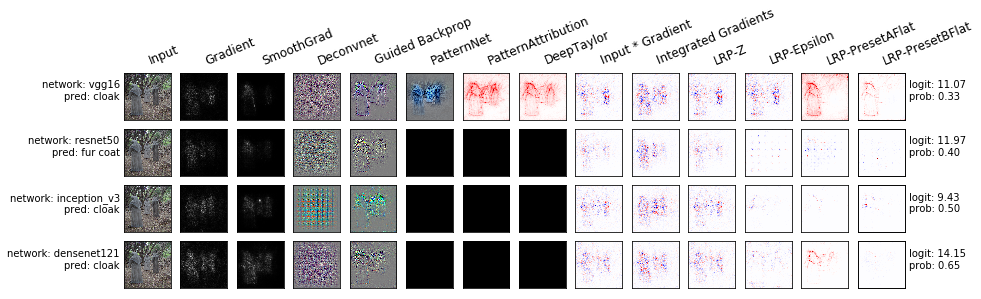

Image nr. 5, true label: Dungeness crab


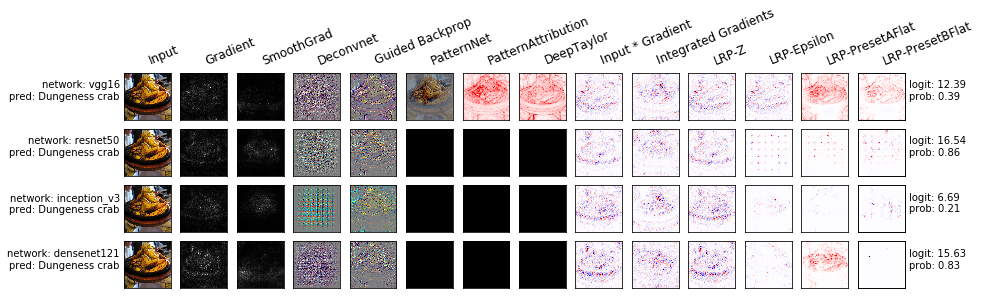

In [ ]:
n_images = analyses["VGG16"].shape[0]

# Prepare common labels
col_labels = ["".join(method[3]) for method in methods]

for image_index in range(n_images):
    grid = []
    row_labels_left = []
    row_labels_right = []

    for network in networks:
        name, _, _ = network
        analysis, text = analyses[name], texts[name]
        # Prepare the grid as rectengular list
        grid.append([analysis[image_index, j] for j in range(analysis.shape[1])])
        # Prepare the labels
        label, presm, prob, pred = zip(*text)
        label = label[image_index]
        row_labels_left.append((f"network: {name}", f"pred: {pred[image_index]}"))
        row_labels_right.append(
            (f"logit: {presm[image_index]}", f"prob: {prob[image_index]}")
        )

    # Plot the analysis.
    print(f"Image Nr. {image_index}, true label: {label}")
    eutils.plot_image_grid(
        grid,
        row_labels_left,
        row_labels_right,
        col_labels,
        file_name=os.environ.get("plot_file_name", None),
    )

This figures show the analysis regarding the *actually predicted* class as computed by the selected analyzers. Each column shows the visualized results for different analyzers and each row shows the analyses wrt to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).